# Learning Theory from First Principles

## Chapter 6 : Local averaging methods

### Generic packages, settings and helper functions



#### Packages

In [ ]:
from google.colab import files
import numpy as np
from numpy.random import randn, rand
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from scipy.stats import ortho_group
from scipy.special import erfinv, gamma
from scipy.linalg import sqrtm, eigh
from bisect import bisect
import tqdm
import warnings

np.random.seed(seed=1)

#### Settings

The code below is used to standardize the appearance of the graphics. The graphs may appear unevenly sized when displayed in this notebook, but once downloaded they are the correct size.

In [ ]:
# Appearance of the graphs

# adujst font
SMALL_FONT = 5
MED_FONT = 8
BIG_FONT = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_FONT
mpl.rcParams['axes.titlesize'] = SMALL_FONT

# adujst lines and markers
mpl.rcParams['axes.linewidth'] = .3
mpl.rcParams['lines.linewidth'] = .7
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['patch.linewidth'] = .3
mpl.rcParams['errorbar.capsize'] = 1.5
mpl.rcParams['lines.markeredgewidth'] = .3

# withdraw the ticks
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0

# adjust legend box
mpl.rcParams['legend.fancybox'] = 0
mpl.rcParams['legend.shadow'] = 0
mpl.rcParams['legend.framealpha'] = 1

# adjust fig general settings
mpl.rcParams['figure.dpi'] = 600

big_rectangle = (6.5, 3.5) # height = 9 cm, width = 17 cm
medium_rectangle = (4.7, 1.6) # height = 4 cm, width = 12 cm
medium_square = (4.7, 4.7) # height = 12 cm, width = 12 cm
small_rectangle = (2.4, 1.6) # height = 6 cm, width = 4 cm
mpl.rcParams['figure.figsize'] = small_rectangle

inner_space = {'wspace':.5, 'hspace':.5}

# savefig params
mpl.rcParams["savefig.bbox"] = 'tight'

#### Helper functions

In [ ]:
def mse(y_hat, y):
  return np.mean((y - y_hat)**2)

zero_one = np.vectorize(lambda u: 1 if u<0 else 0)
hinge = np.vectorize(lambda u: np.maximum(1-u, 0))
square = np.vectorize(lambda u: (1-u)**2)
logis = np.vectorize(lambda u: np.log(1+np.exp(-u)))

### Figures

#### Fig 6.2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

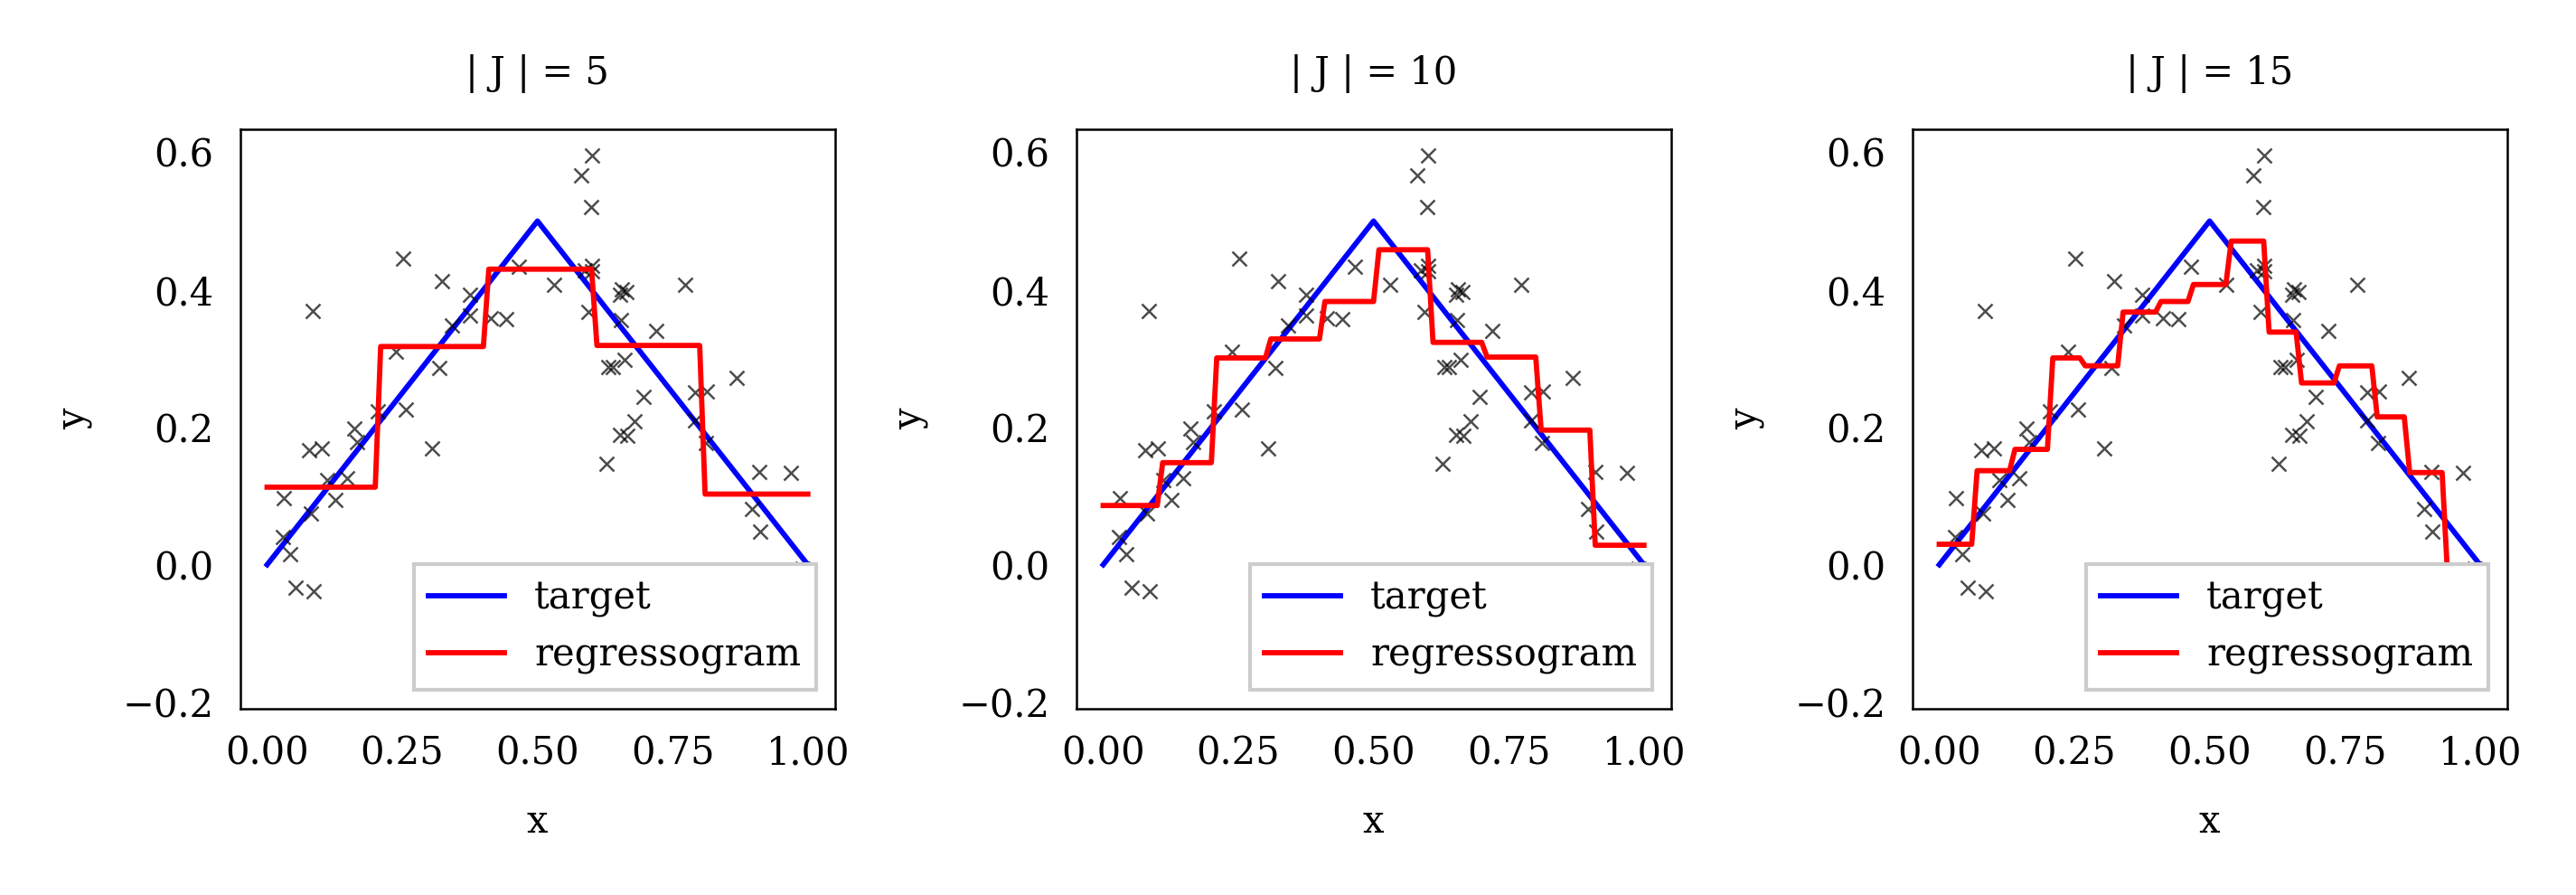

In [ ]:
target = lambda x: -np.abs(x-0.5)+0.5
target = np.vectorize(target)

def stepF(w, J):
    bin = np.linspace(0, 1, J+1)
    def f(x):
        for b in range(len(bin)-1):
            if x <= bin[b+1]:
                return w[b]
    f = np.vectorize(f)
    return f

def regressoPredict(J, x_obs, y_obs):
    bins = np.linspace(0, 1, J+1)
    weights = np.zeros(J)
    for j in range(J):
        index = [i for i in range(len(x_obs)) if (x_obs[i] < bins[j+1] and x_obs[i]>bins[j]) ]
        weights[j] = np.mean(y_obs[index]) if len(index)>0 else 0
    fJ = stepF(weights, J)
    return fJ

def plotFixedPartition(figure, x, y, j, i, x_obs, y_obs):
    axes = figure.add_subplot(1, 3, i)
    axes.plot(x, y ,'b', label='target')
    axes.plot(x_obs, y_obs, 'xk', alpha = 0.7)
    fJ = regressoPredict(j, x_obs, y_obs)
    axes.plot(x, fJ(x), 'r', label='regressogram')
    axes.set_title(f'| J | = {j}')
    axes.legend(loc='lower right')
    axes.set_xlabel('x')
    axes.set_ylabel('y')

figure = plt.figure(figsize = medium_rectangle, tight_layout=True)
x = np.linspace(0, 1, 101)
y = target(x)

n = 60
std_noise = 0.1
x_obs = np.sort(np.random.uniform(0, 1, n))
y_obs = target(x_obs) + std_noise*np.random.randn(n)
J = [5, 10, 15]
for i in range(len(J)):
    plotFixedPartition(figure, x, y, J[i], i+1, x_obs, y_obs)

plt.savefig('fig62.svg')
files.download("fig62.svg")

#### Fig 6.3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

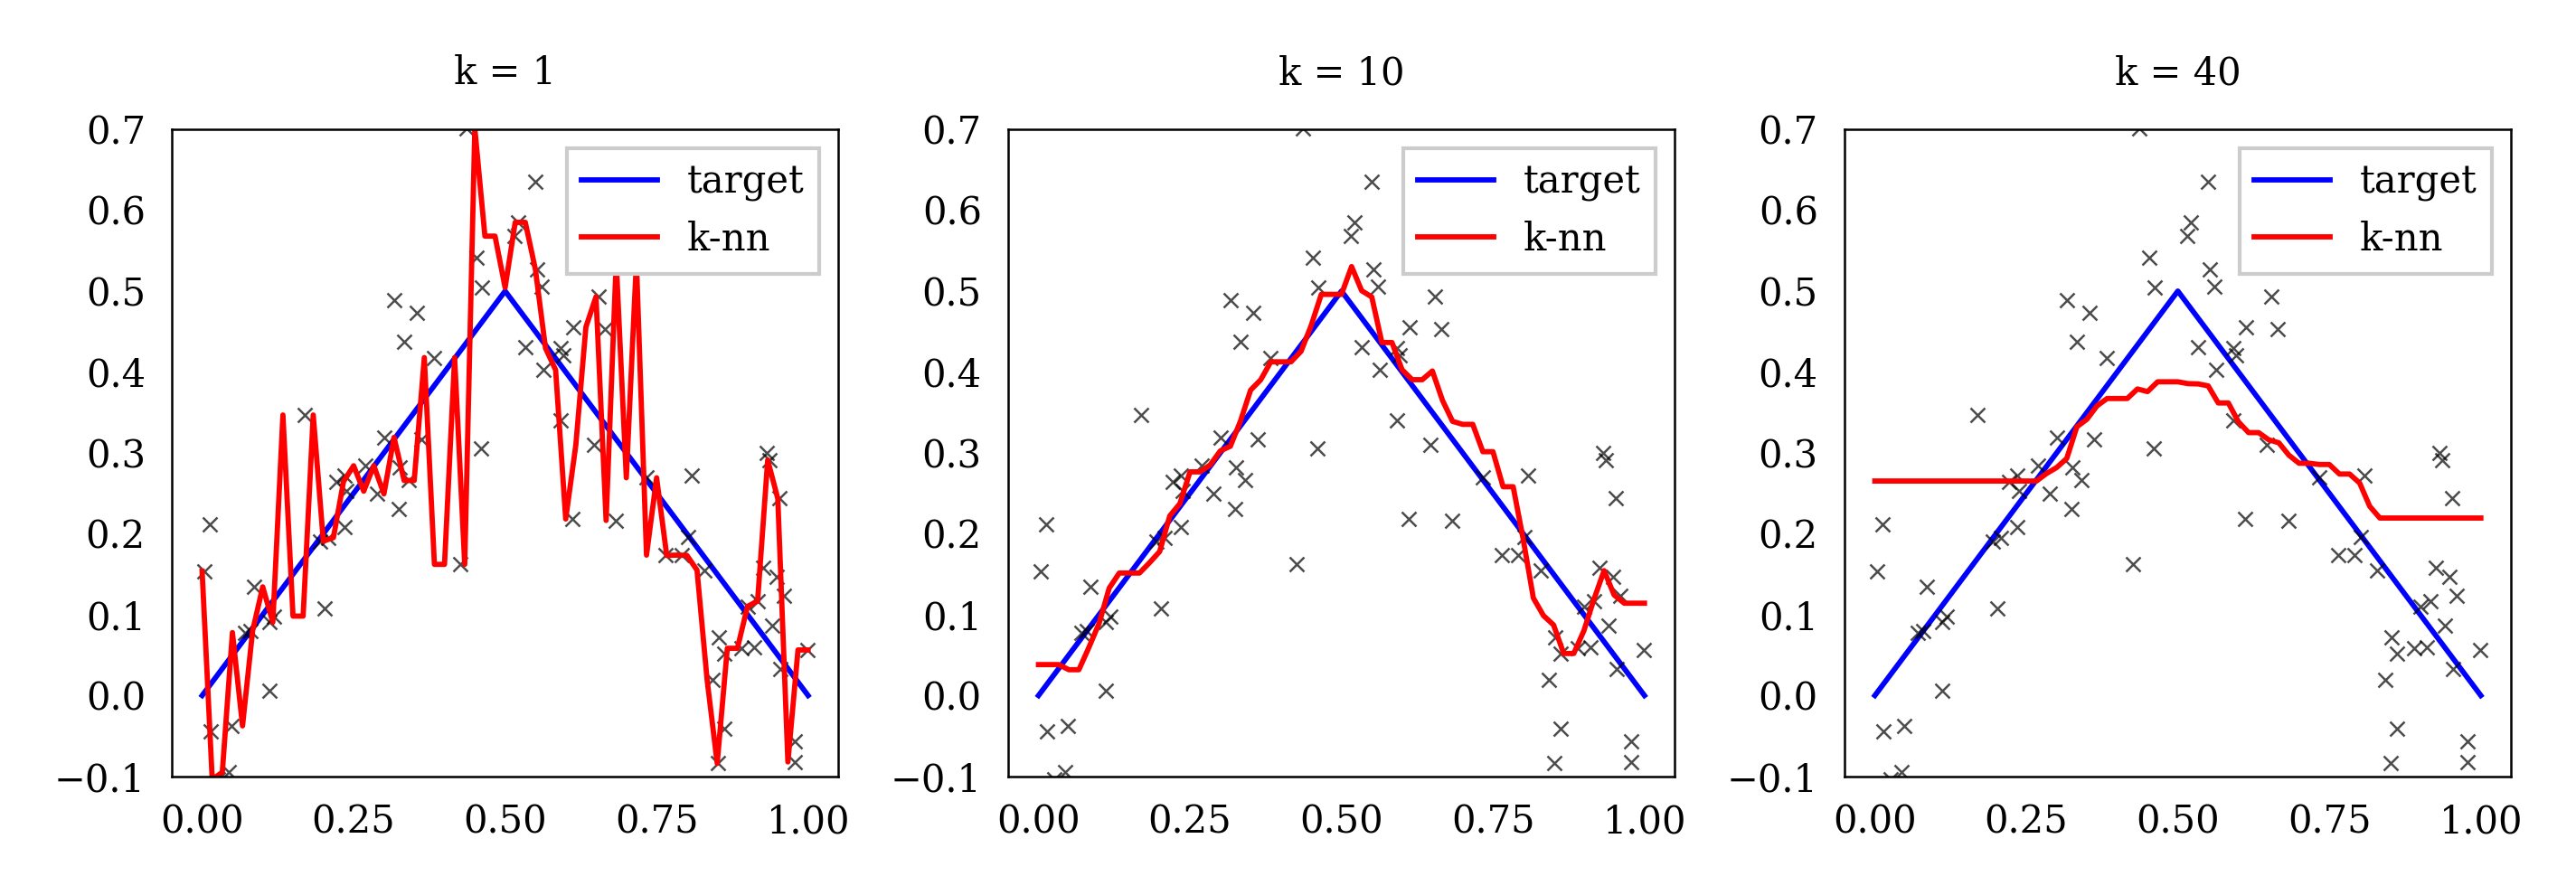

In [ ]:
def knn1(newinputx, obs_x, obs_y, n):
    f1 = np.zeros(len(newinputx))
    indices = np.zeros(len(newinputx))
    for i in range(len(newinputx)):
        indexafter = bisect((obs_x), newinputx[i])
        d1 = np.abs(newinputx[i] - obs_x[indexafter]) if indexafter<len(newinputx) else np.abs(newinputx[i] - obs_x[indexafter-1])
        d2 = np.abs(newinputx[i] - obs_x[indexafter-1])
        index = indexafter-1 if ((d2 > d1) and indexafter>0) else indexafter
        if (index==n):
          index-=1
        indices[i] = index
        f1[i] = obs_y[index]
    return f1

def knn(k, newinputx, obs_x, obs_y, n):
    if k==1:
        return knn1(newinputx, obs_x, obs_y, n)
    fk = np.zeros(len(newinputx))
    for i in range(len(newinputx)):
        indexafter = bisect((obs_x), newinputx[i])
        if indexafter<k//2:
            indices = [j for j in range(0,k)]
        elif indexafter>n-k//2:
            indices = [j for j in range(n-k, n)]
        else:
            indices = [j for j in range(indexafter-k//2, indexafter+k//2)]
        fk[i] = np.mean(obs_y[indices])
    return fk

target = lambda x: -np.abs(x-0.5)+0.5
target = np.vectorize(target)

def plotKNN(figure, k, i, x_obs, y_obs, y_pred):
    axes = figure.add_subplot(1, 3, i)
    axes.plot(xtrain, ytrain ,'b', label='target')
    axes.plot(x_obs, y_obs, 'kx', alpha = 0.7)
    axes.plot(xtrain, y_pred, 'r', label='k-nn')
    axes.set_ylim(-0.1, 0.7)
    axes.legend(loc='upper right')
    axes.set_title(f'k = {k}')


n=80
xtrain = np.linspace(0, 1, 61)
ytrain = target(xtrain)
xtest = np.sort(np.random.uniform(0, 1, n))
ytest = target(xtest) + 0.12*np.random.randn(n)

#Values of k
K = [1, 10, 40]

# Plot
figure = plt.figure(figsize = medium_rectangle, tight_layout=True)
i = 1
for k in K:
  f = knn(k, xtrain, xtest, ytest, n)
  plotKNN(figure, k, i, xtest, ytest, f)
  i = i+1

plt.savefig('fig63.svg')
files.download("fig63.svg")


#### Fig 6.4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

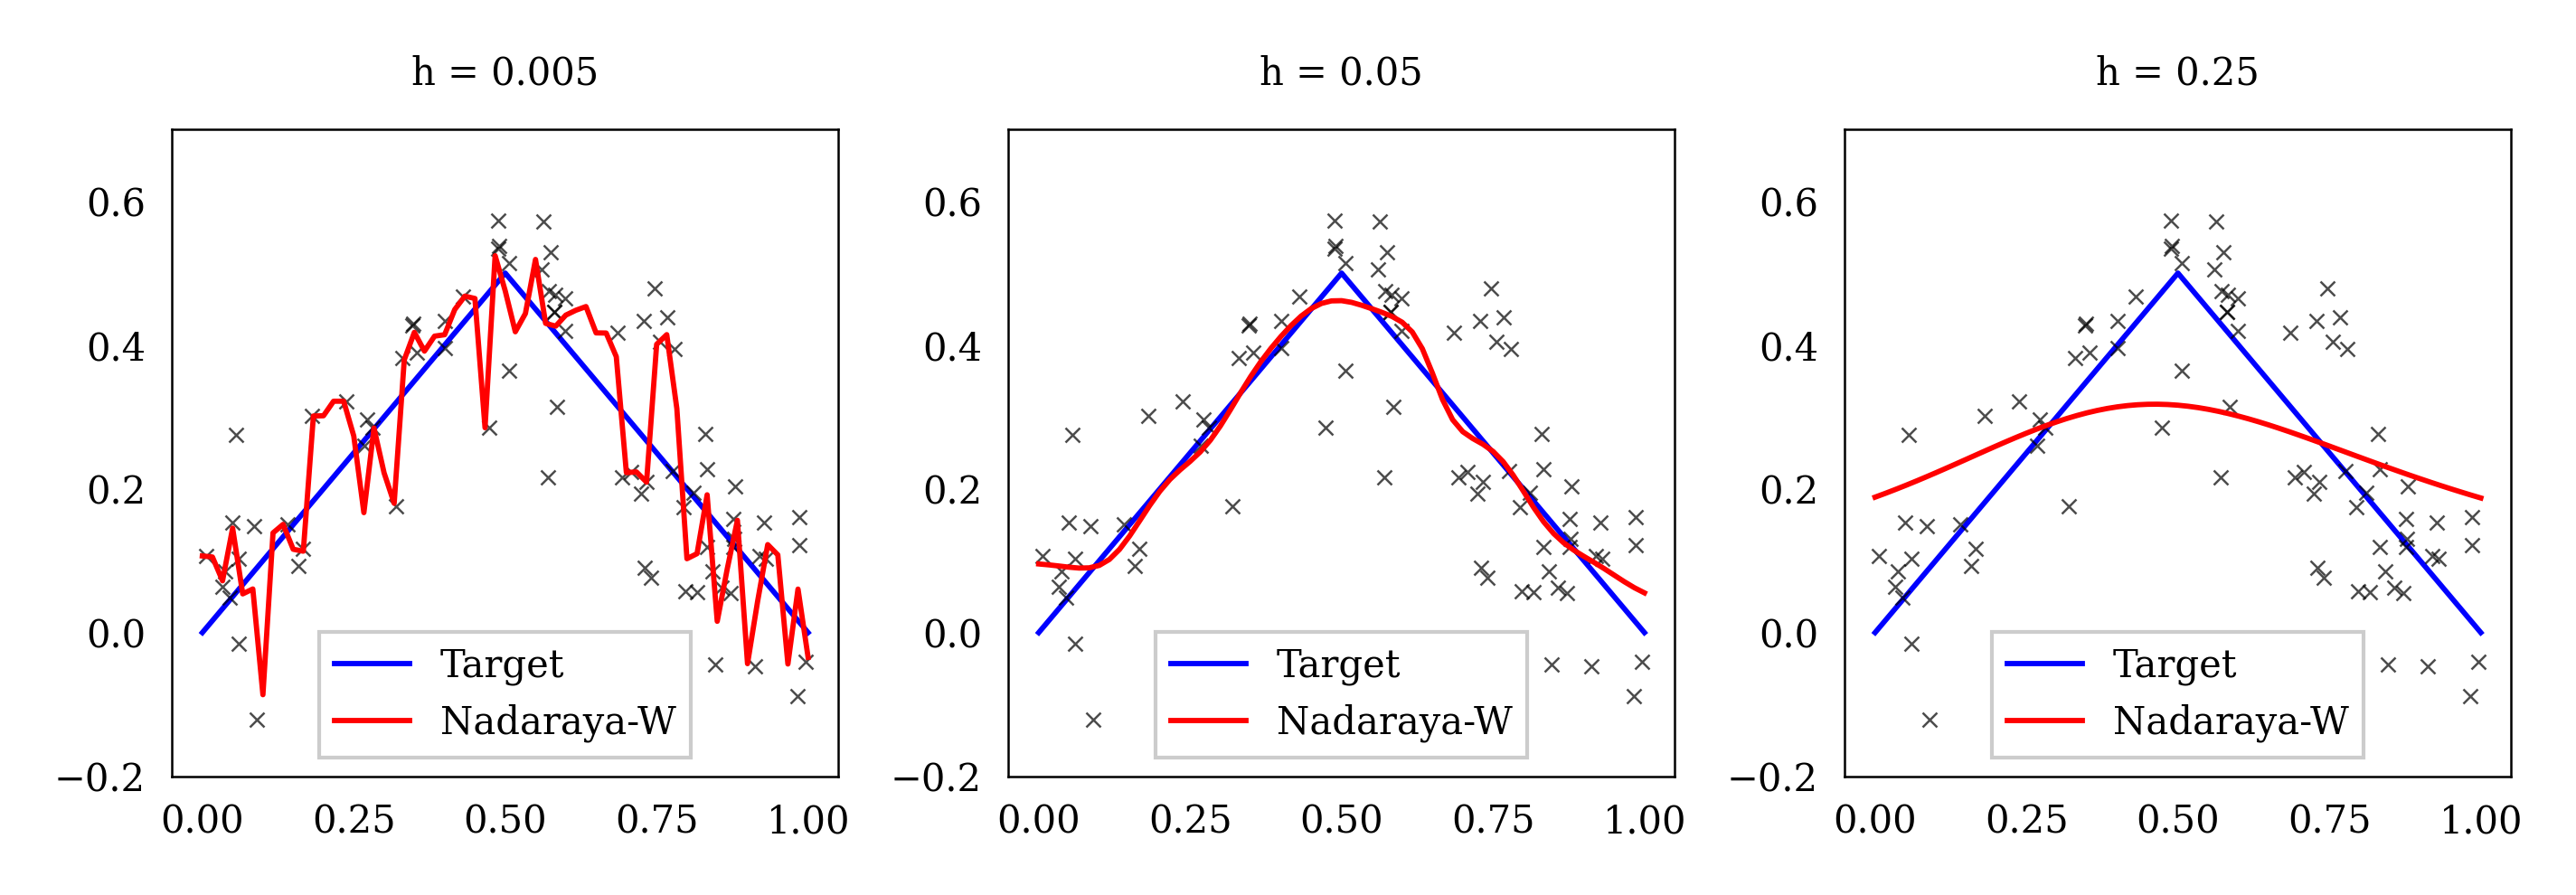

In [ ]:
q = lambda x: np.exp(-np.sum(x**2)/2)

def k(x, x_, h, d=1):
    return h**(-d) * q((1/h)*(x-x_))

def NW_predict(x_in, y_obs, h, x_obs):
    weights = np.array([k(x_in, x_obs[i], h) for i in range(n)])
    weights = weights / np.sum(weights)
    return np.dot(weights, y_obs)

target = lambda x: -np.abs(x-0.5)+0.5
target = np.vectorize(target)


def plot_NW_h(figure, h, index):
    f1 = [NW_predict(x, Ytest, h, Xtest) for x in Xtrain]
    axes = figure.add_subplot(1, 3, index)
    axes.plot(Xtrain, Ytrain ,'b', label='Target')
    axes.plot(Xtest, Ytest, 'kx', alpha = 0.7)
    axes.plot(Xtrain, f1, 'r', label='Nadaraya-W')
    axes.legend()
    axes.set_ylim([-0.2, 0.7])
    axes.set_title(f'h = {h}')

figure = plt.figure(figsize = medium_rectangle, tight_layout=True)
d = 1
n = 80
Xtrain = np.linspace(0, 1, 61) #odd to have point in graph at max
Ytrain = target(Xtrain)
Xtest = np.sort(np.random.uniform(0, 1, n))
Ytest = target(Xtest) + 0.12*np.random.randn(n)

H = [0.005, 0.050, 0.250]
for i in range(len(H)):
    plot_NW_h(figure, H[i], i+1)

plt.savefig('fig64.svg')
files.download("fig64.svg")

#### Fig 6.5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

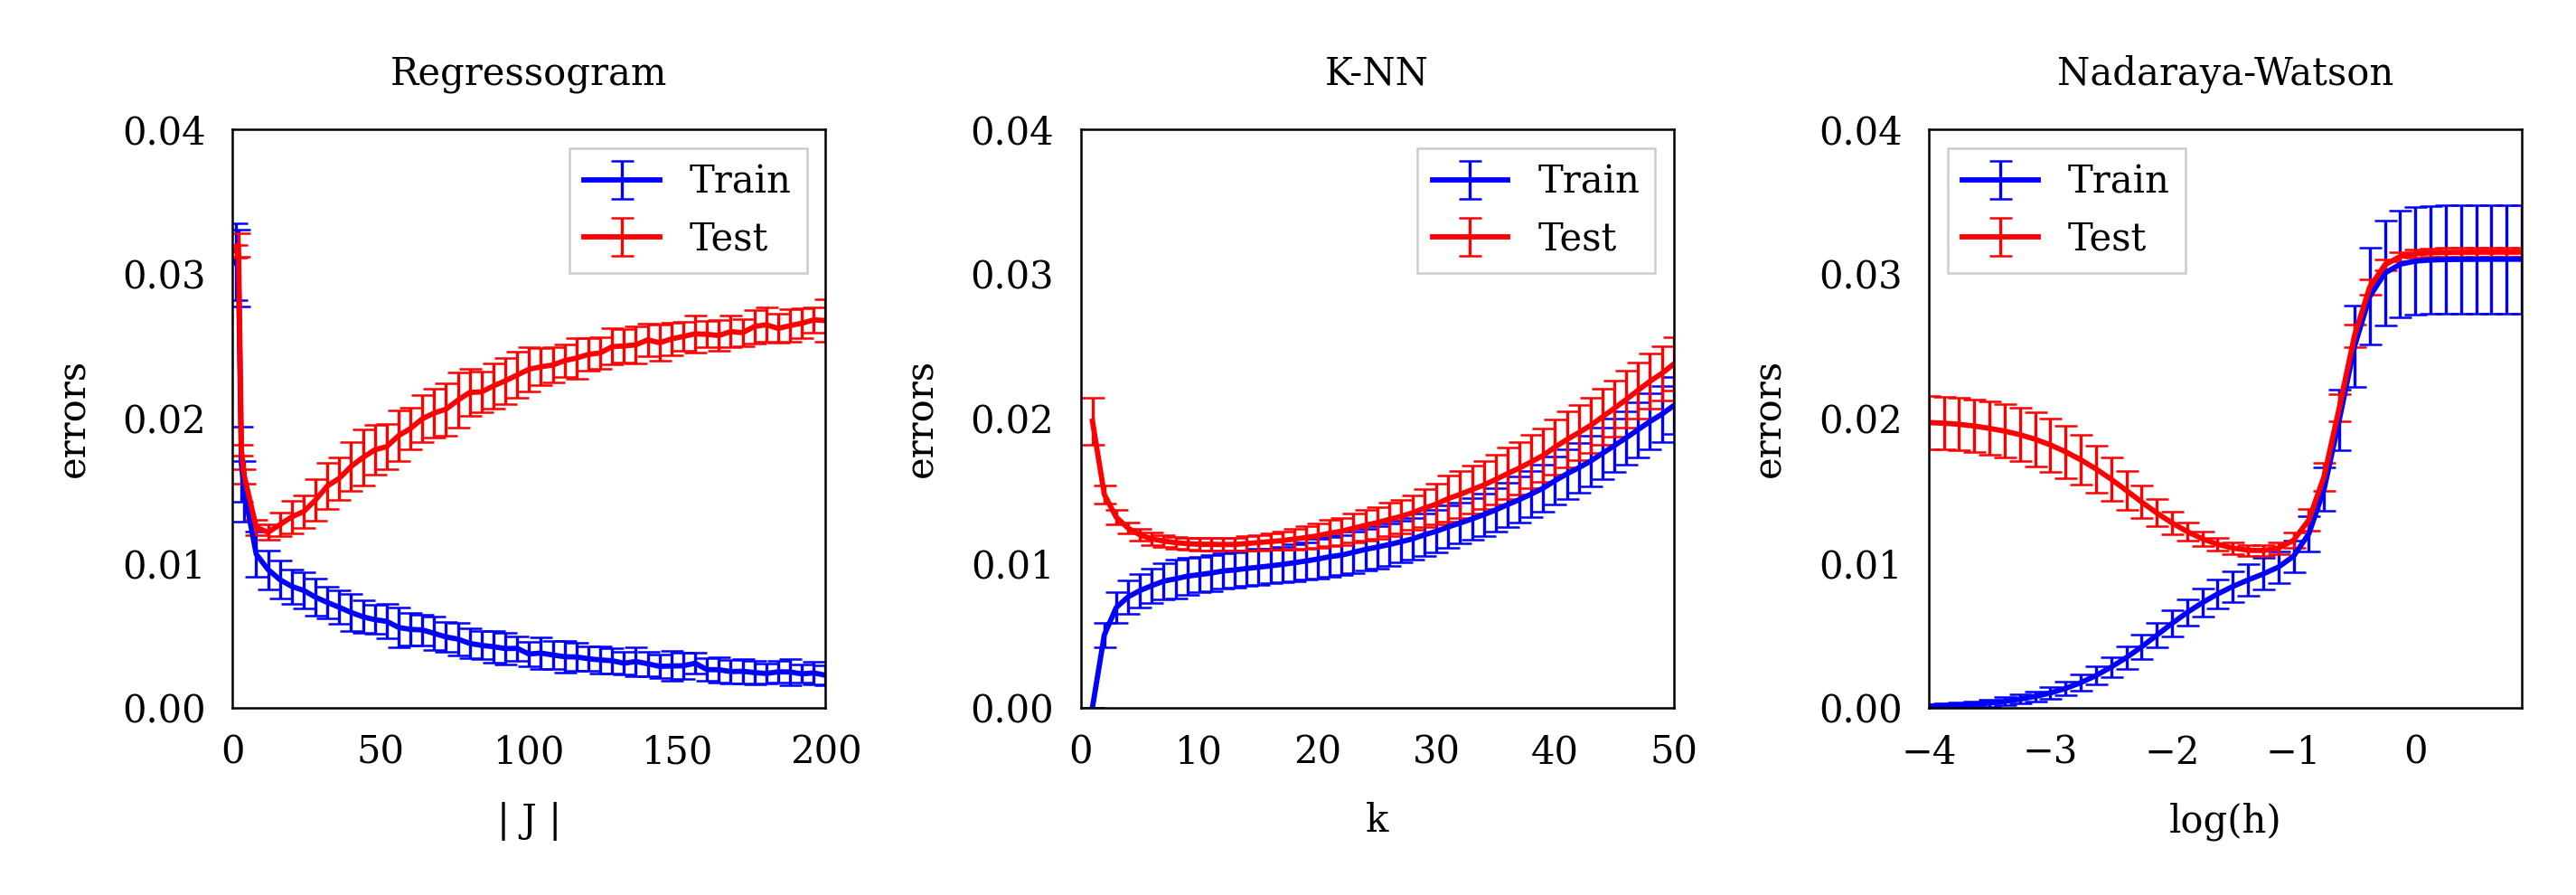

In [ ]:
l10 = np.log10

nrep = 32
n = 100
sdnoise = .1

def genDat(n, sd):
    Xtrain = np.random.rand(n,1)
    ytrain = 0.5 - np.abs(Xtrain - 0.5) + sd * np.random.randn(n,1)
    Xtest =np.arange(0, 1.01, 0.01)
    ytest = 0.5 - np.abs(Xtest - 0.5)
    return Xtrain, ytrain, Xtest, ytest

#Regresso
Jcards = [1,2,3] + [4*i for i in range(1,51)]
trainerrReg = np.zeros((nrep, len(Jcards)))
testerrReg = np.zeros((nrep, len(Jcards)))
for irep in range(nrep):
    Xtrain, ytrain, Xtest, ytest = genDat(n, sdnoise)

    for icard in range(len(Jcards)):
        Jcard = Jcards[icard]
        ftest = Xtest*0
        ftrain = Xtrain*0

        bintest = np.ceil(Xtest*Jcard)
        bintest = bintest + (bintest==0)
        bintrain = np.ceil(Xtrain*Jcard)
        bintrain = bintrain + (bintrain==0)

        for itest in range(len(Xtest)):
            x = Xtest[itest]
            bin = bintest[itest]
            ind = np.where(bintrain==bin)
            if np.size(ind)==0:
                ftest[itest] = np.mean(ytrain)
            else:
                ftest[itest] = np.mean(ytrain[ind])

        for itrain in range(len(Xtrain)):
            x = Xtest[itrain]
            bin = bintrain[itrain]
            ind = np.where(bintrain==bin)
            if np.size(ind)==0:
                ftrain[itrain] = np.mean(ytrain)
            else:
                ftrain[itrain] = np.mean(ytrain[ind])

        trainerrReg[irep, icard] = mse(ytrain, ftrain)
        testerrReg[irep, icard] = mse(ytest, ftest) + sdnoise**2

#K-NN
K = np.arange(1, 51, 1)

trainerrKNN = np.zeros((nrep, len(K)))
testerrKNN = np.zeros((nrep, len(K)))

for irep in range(nrep):
    Xtrain, ytrain, Xtest, ytest = genDat(n, sdnoise)

    for ik in range(len(K)):
        k = K[ik]
        ftest = Xtest*0
        ftrain = Xtrain*0

        for itest in range(len(Xtest)):
            x = Xtest[itest]
            b = np.argsort(np.abs(Xtrain-x), axis=0)
            ftest[itest] = np.mean(ytrain[b[:k]])

        for itrain in range(len(Xtrain)):
            x = Xtrain[itrain]
            b = np.argsort( np.abs(Xtrain-x), axis=0)
            ftrain[itrain] = np.mean(ytrain[b[:k]])

        trainerrKNN[irep, ik] = mse(ytrain, ftrain)
        testerrKNN[irep, ik] = mse(ytest, ftest) + sdnoise**2

#Nad-Wats
H = 10**np.arange(-4,1, 0.125)
trainerrNW = np.zeros((nrep, len(H)))
testerrNW = np.zeros((nrep, len(H)))

for irep in range(nrep):
    Xtrain, ytrain, Xtest, ytest = genDat(n, sdnoise)

    for ih in range(len(H)):
        h = H[ih]
        ftest = Xtest*0
        ftrain = Xtrain*0

        for itest in range(len(Xtest)):
            x = Xtest[itest]
            temp = np.exp(-(np.abs(x-Xtrain) - np.min(np.abs(x-Xtrain)))**2 / 2/h/h)
            ftest[itest] = (temp.T.dot(ytrain))/np.sum(temp)

        for itrain in range(len(Xtrain)):
            x = Xtrain[itrain]
            temp = np.exp(-( np.abs(x-Xtrain) -np.min(np.abs(x-Xtrain)) )**2 / 2/h/h)
            ftrain[itrain] = temp.T.dot(ytrain) / np.sum(temp)

        trainerrNW[irep, ih] = mse(ytrain, ftrain)
        testerrNW[irep, ih] = mse(ytest, ftest) + sdnoise**2


plt.figure(figsize = medium_rectangle, tight_layout=True)
plt.subplot(1,3,1)
plt.errorbar(x=Jcards, y=np.mean(trainerrReg, 0), yerr=np.std(trainerrReg, 0), c='b', elinewidth = 0.4)
plt.errorbar(x=Jcards, y=np.mean(testerrReg, 0), yerr=np.std(testerrReg, 0), c='r', elinewidth = 0.4)
plt.xlabel('| J |')
plt.ylabel('errors')
plt.legend(('Train', 'Test'))
plt.title('Regressogram')
plt.xlim(0,200)
plt.ylim(0, 0.04);

plt.subplot(1,3,2)
plt.errorbar(x=K, y=np.mean(trainerrKNN, axis=0), yerr=np.std(trainerrKNN, axis=0), c='b', elinewidth = 0.4)
plt.errorbar(x=K, y=np.mean(testerrKNN, axis=0), yerr=np.std(testerrKNN, 0), c='r', elinewidth = 0.4)
plt.xlabel('k')
plt.ylabel('errors')
plt.legend(('Train', 'Test'))
plt.title('K-NN')
plt.xlim(0,50)
plt.ylim(0, 0.04);

plt.subplot(1,3,3)
plt.errorbar(x=l10(H), y=np.mean(trainerrNW, 0), yerr=np.std(trainerrNW, 0), c='b', elinewidth = 0.4)
plt.errorbar(x=l10(H), y=np.mean(testerrNW, 0), yerr=np.std(testerrNW, 0), c='r', elinewidth = 0.4)
plt.xlabel('log(h)')
plt.ylabel('errors')
plt.legend(('Train', 'Test'))
plt.title('Nadaraya-Watson')
plt.xlim(np.min(l10(H)),np.max(l10(H)))
plt.ylim(0, 0.04);

plt.savefig('fig65.svg')
files.download("fig65.svg")


#### Fig 6.6

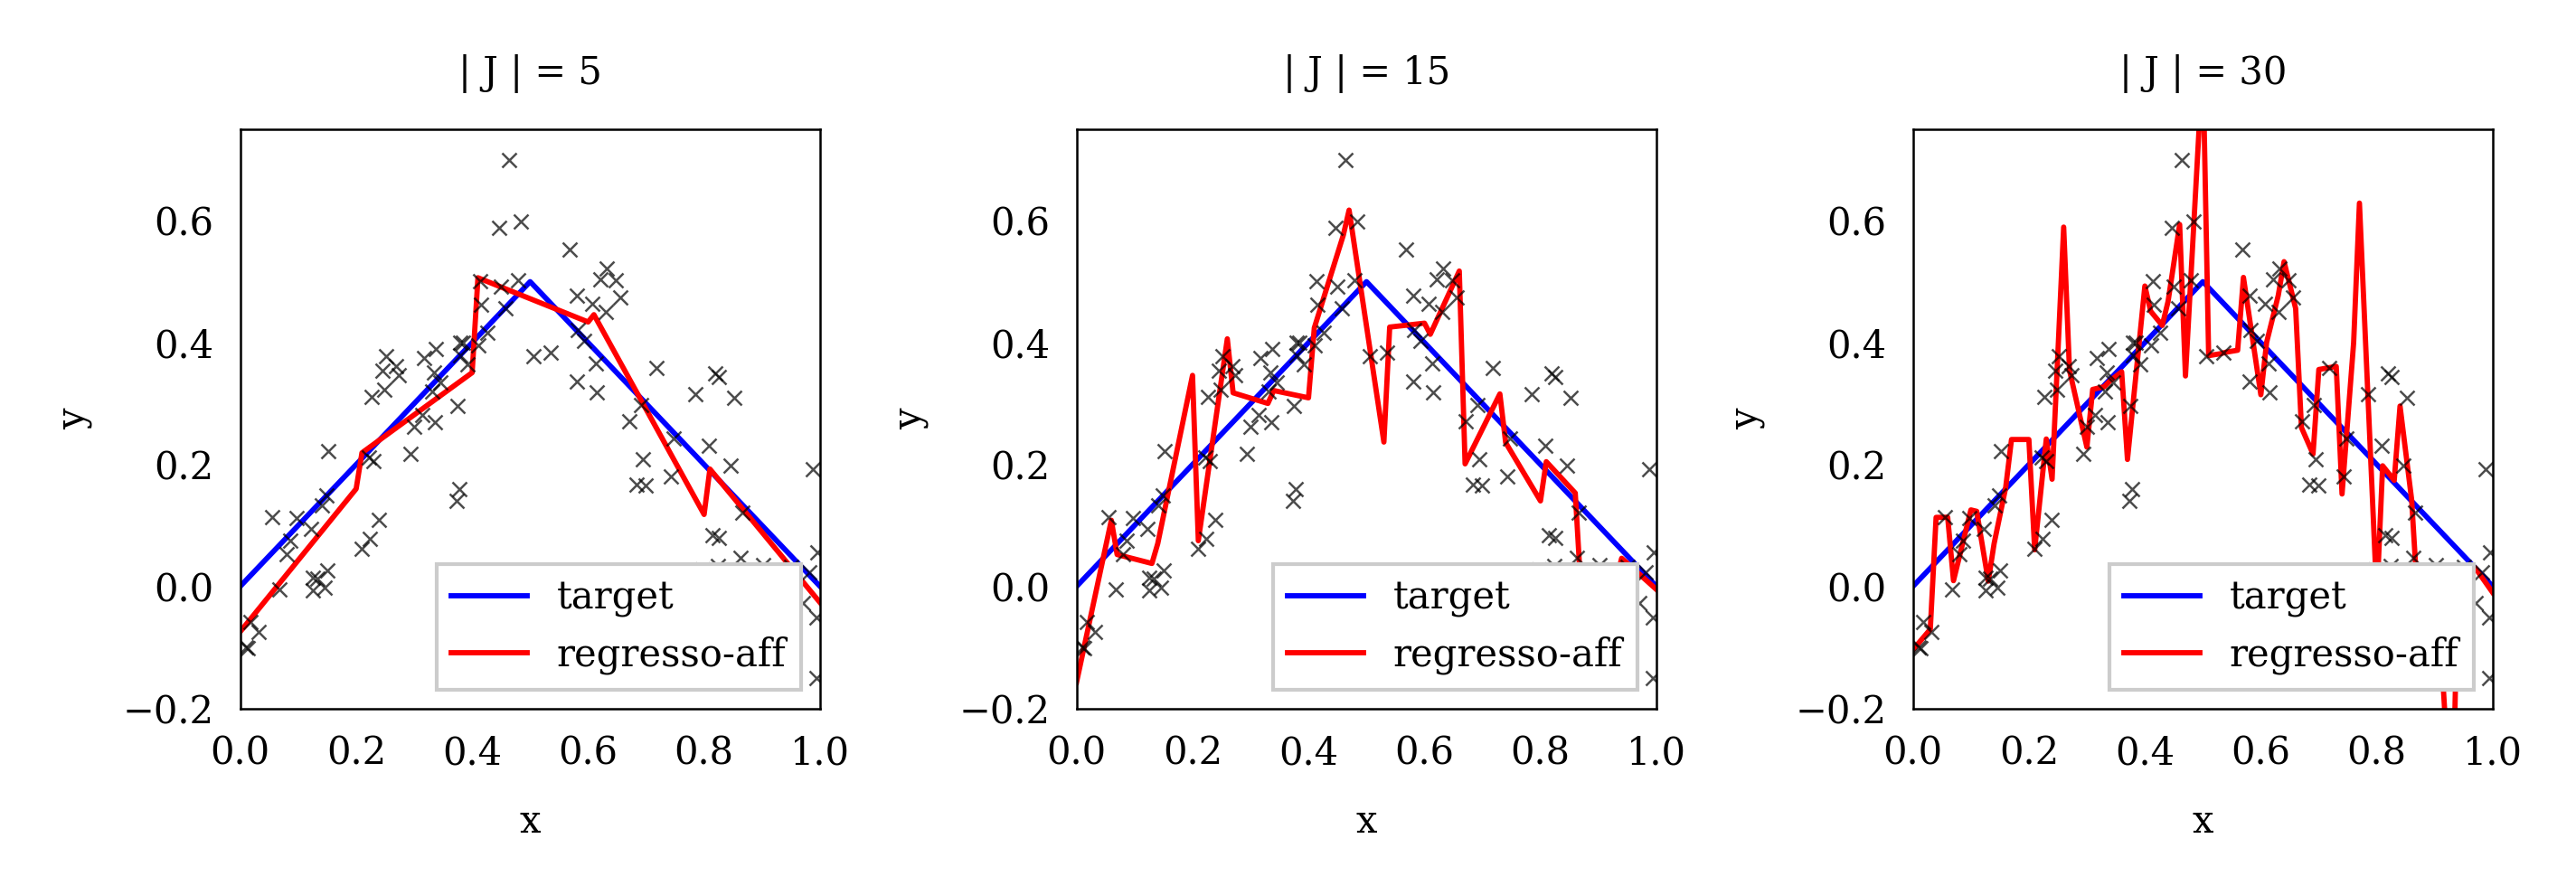

In [ ]:
l10 = np.log10

nrep = 32
n = 100
sdnoise = .1

def genDat(n, sd):
    Xtrain = np.random.rand(n,1)
    ytrain = 0.5 - np.abs(Xtrain - 0.5) + sd * np.random.randn(n,1)
    Xtest =np.arange(0, 1.01, 0.01)
    ytest = 0.5 - np.abs(Xtest - 0.5)
    return Xtrain, ytrain, Xtest, ytest

Xtrain, ytrain, Xtest, ytest = genDat(n=n, sd=sdnoise)

Jcards = [5, 15, 30]

ftest = np.zeros((len(Xtest), len(Jcards)))

for it in range(len(Jcards)):
    Jcard = Jcards[it]
    bintest = np.ceil(Xtest*Jcard)
    bintest = bintest + (bintest==0)
    bintrain = np.ceil(Xtrain*Jcard)
    bintrain = bintrain + (bintrain==0)

    for itest in range(len(Xtest)):
        x = Xtest[itest]
        bin = bintest[itest]
        ind = list(np.where(bintrain==bin)[0])
        if np.size(ind)==0:
            ftest[itest, it] = np.mean(ytrain)
        else:
            yloc = ytrain[ind]
            Xloc = np.vstack( (Xtrain[ind,0], np.ones(len(ind))) ).T
            th = np.linalg.lstsq(Xloc.T.dot(Xloc), Xloc.T.dot(yloc), rcond=None)[0]
            ftest[itest, it] = np.hstack((Xtest[itest], 1)).dot(th)

plt.figure(figsize = medium_rectangle, tight_layout = True)
for i in range(len(Jcards)):
    plt.subplot(1,3,i+1)
    plt.plot(Xtest, ytest, 'b')
    plt.plot(Xtest, ftest[:, i], 'r')
    plt.plot(Xtrain, ytrain, 'xk', alpha=0.7)
    plt.title(f'| J | = {Jcards[i]}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim((0,1))
    plt.ylim((-0.2, 0.75))
    plt.legend(('target', 'regresso-aff'), loc='lower right');

plt.savefig('fig66.svg')
files.download("fig66.svg")